In [21]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch_geometric
from torch_geometric.loader import DataLoader
import pandas as pd
import random
import os
from torch_geometric.data import Data, Batch
import networkx as nx
from torch_geometric.utils import to_networkx
import torch.nn.functional as F
from torch_geometric.nn import NNConv, global_mean_pool
from tqdm import tqdm
import torch.optim as optim
import json
import pprint 
import traceback
import seaborn as sns

In [4]:
from helper_function_module import init_setup
seed = 72
BATCH_SIZE = 70
device = init_setup(batch_size = BATCH_SIZE, 
           use_cuda = True, 
           random_seed = seed)

Using device: cpu
System CUDA Status:
- PyTorch version: 2.5.1+cu121
- CUDA Version: 12.1
- CUDA available: False

PyTorch Geometric Status:
- PyG version: 2.6.1
- torch_scatter: Installed
- torch_sparse: Installed
- torch_cluster: Installed
- torch_spline_conv: Installed


# Importing the Main tabular data

In [5]:
BASE_JSON_DATA_DIR = "/teamspace/studios/this_studio/all/txt_data_preprocess/GNN_JSON_DATA"
signal_path = os.path.join(BASE_JSON_DATA_DIR, "onlyFirst2bj_onlyFirst1p/ppzaxbba_ax15_200k_minpt10_15jets_etafiltered_onlyFirst2bj_onlyFirst1p_GNN_JSON_data.json")
background_path = os.path.join(BASE_JSON_DATA_DIR, "onlyFirst2bj_onlyFirst1p/background_ppbba_500k_minpt10_15jets_etafiltered_onlyFirst2bj_onlyFirst1p_GNN_JSON_data.json")

with open(signal_path, 'r') as file:
    signal = json.load(file)

with open(background_path, 'r') as file:
    background = json.load(file)

In [6]:
pp = pprint.PrettyPrinter(indent=1)

print(f"Signal Event: {len(signal)}")
print("Example:")
pp.pprint(signal[np.random.randint(0, len(signal))])
print(100*'~')

print(f"Background Event: {len(background)}")
print("Example:")
pp.pprint(background[np.random.randint(0, len(background))])

Signal Event: 1937
Example:
{'edge_index': [[0, 1, 0, 2, 1, 2], [1, 0, 2, 0, 2, 1]],
 'edges': [3.0425649789660754,
           3.0425649789660754,
           3.209281312165852,
           3.209281312165852,
           0.4292468785768861,
           0.4292468785768861],
 'event_label': 1,
 'eventno': 50041,
 'inv_mass_2j': 10.44059908345781,
 'inv_mass_2j1p': 88.78766338717897,
 'isophoton_pT': 28.4699,
 'jet_btag_label': [0, 1.0, 1.0],
 'node_labels': [0, 1, 1],
 'nodes': [[-1.05123, 2.9514, 28.4699, 45.704],
           [0.144288, -0.53394, 34.8586, 35.2221],
           [-0.173124, -0.244972, 16.947, 17.2016]],
 'num_btag_jets': 2,
 'num_isophotons': 1,
 'num_nodes': 3}
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Background Event: 3823
Example:
{'edge_index': [[0, 1, 0, 2, 1, 2], [1, 0, 2, 0, 2, 1]],
 'edges': [0.7690864197637349,
           0.7690864197637349,
           2.328479748673941,
           2.328479748673941,
         

# Converting Each Event into a PyG Graph Object

In [7]:
def convert_to_pyg_graph(graph, normalize_features):
    """
    Convert the graph dictionary into a PyTorch Geometric Data object
    and add graph-level features like jet_multiplicity, inv_mass, and the event label.

    Parameters:
    -----------
    graph : dict
        Dictionary containing 'eventno', 'nodes', 'edges', and 'edge_index', 'jet_multiplicity', 'inv_mass', 'node_labels',
        'jet_btag_labels', 'event_label' for a single event.

    Returns:
    --------
    data : Data
        PyTorch Geometric Data object containing the graph and additional features.
    """
    # Extract node features, edge features, and edge index from the graph dictionary
    event_num = torch.tensor(graph['eventno'], dtype=torch.long)
    # edge_index = torch.tensor(graph['edge_index'], dtype=torch.long)  # Shape: (2, num_edges)
    edge_index_raw = graph['edge_index']
    if not edge_index_raw or len(edge_index_raw) == 0:  # Empty edge_index
        edge_index = torch.empty(2, 0, dtype=torch.long)  # Shape: (2, 0)
        edge_features = torch.empty(0, 1, dtype=torch.float)  # Shape: (0, 1)
    else:
        edge_index = torch.tensor(edge_index_raw, dtype=torch.long)
        # Ensure edge_index is 2D with shape [2, num_edges]
        if edge_index.dim() == 1:  # If 1D, assume it's a flat list like [0, 1]
            edge_index = edge_index.view(2, -1)  # Reshape to [2, num_edges]
        elif edge_index.dim() != 2 or edge_index.size(0) != 2:  # Invalid shape
            raise ValueError(f"Invalid edge_index shape: {edge_index.shape}. Expected [2, num_edges].")
    
    
    edge_features = torch.tensor(graph['edges'], dtype=torch.float).view(-1,1)  # Shape: (num_edges, 1)
    
    node_labels = torch.tensor(graph['node_labels'], dtype=torch.long).view(-1,1)
    jet_btag_labels = torch.tensor(graph['jet_btag_label'], dtype=torch.long).view(-1,1)

    node_features = torch.tensor(graph['nodes'], dtype=torch.float)

    if (normalize_features) & (node_features.size(0) != 0):
        node_features = (node_features - node_features.mean(dim=0)) / node_features.std(dim=0) #Normalised Features
    
    node_features_with_btaglabel = torch.cat((node_features[:, :2], jet_btag_labels), dim = 1)

    
            
    # Convert graph-level features (jet_multiplicity, inv_mass) and label to tensor
    graph_level_features = torch.tensor([graph['num_nodes'],
                                         graph['inv_mass_2j1p'],
                                         graph['inv_mass_2j'],
                                         graph['num_isophotons'],
                                         graph['num_btag_jets'],
                                         graph['isophoton_pT']
                                        ], dtype=torch.float).view(1, -1)
    label_tensor = torch.tensor(graph['event_label'], dtype=torch.long)  # Event label (0 or 1)

    # Create the PyTorch Geometric Data object
    data = Data(
        x=node_features_with_btaglabel,               # Node features (3, num_features)
        edge_index=edge_index,         # Edge index (2, num_edges)
        edge_attr=edge_features,       # Edge features (num_edges, 1)
        y=label_tensor                 # Event label (0 or 1)
    )

    # Add custom graph-level features
    data.eventno = event_num
    data.number_of_nodes = graph_level_features[0, 0]
    data.inv_mass_2j1p = graph_level_features[0, 1]
    data.inv_mass_2j = graph_level_features[0, 2]
    data.num_isophotons = graph_level_features[0, 3]
    data.num_btag_jets = graph_level_features[0, 4]
    data.node_label = node_labels 
    data.jet_btag_label = jet_btag_labels
    data.isophoton_pT = graph_level_features[0, 5]

    return data

def convert_all_to_pyg_graphs(graphs,*, normalize_features = False):
    """
    Converts a list of event graphs to PyTorch Geometric-compatible Data objects.
    Also adds the graph-level features 'jet_multiplicity', 'inv_mass' and event labels.

    Parameters:
    -----------
    graphs : list of dicts
        List containing dictionaries with node, edge information for each event.
    dataframe : pd.DataFrame
        DataFrame containing the event-level features like 'jetmultiplicity', 'invmass_4j1p', and 'label'.

    Returns:
    --------
    pyg_graphs : list of Data
        List of PyTorch Geometric Data objects with added graph-level features and labels.
    """
    pyg_graphs = []
    print('Initializing the process...')
    with tqdm(total = len(graphs), desc = 'Progress', leave = True) as pbar:    
        for i, graph in enumerate(graphs):
            data = convert_to_pyg_graph(graph, normalize_features)
            pyg_graphs.append(data)
            pbar.update(1)
    print('Process completed successfully :)')
    return pyg_graphs

In [8]:
signal_pyg_graphs = convert_all_to_pyg_graphs(signal, normalize_features = False)
background_pyg_graphs = convert_all_to_pyg_graphs(background, normalize_features = False)

Initializing the process...


Progress: 100%|██████████| 1937/1937 [00:00<00:00, 5057.43it/s]


Process completed successfully :)
Initializing the process...


Progress: 100%|██████████| 3823/3823 [00:01<00:00, 3383.70it/s]

Process completed successfully :)


In [9]:
dataset = []
for data in signal_pyg_graphs + background_pyg_graphs:
    if (data.number_of_nodes >= 3) & (data.num_isophotons == 1) & (data.num_btag_jets == 2):
        dataset.append(data)

In [10]:
random.seed(seed)
dataset = random.sample(dataset, len(dataset))
print(f'Dataset contains {len(dataset)} samples')

Dataset contains 5760 samples


# Train-Test Splits

In [11]:
num_graphs = len(dataset)
train_ratio, test_ratio = 0.7, 0.3
train_size = int(train_ratio * num_graphs)
test_size = num_graphs - train_size

# Random split
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, [train_size, test_size], generator=torch.Generator().manual_seed(seed)
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)


In [12]:
len(train_loader)

58

# Graph Visualization

In [13]:
def visualize_graph(data, *, save_fig=False, save_fig_path=None) -> None:
    """
    Visualize a graph with node features, labels, and edge attributes.
    
    Parameters:
    -----------
    data : Data
        PyTorch Geometric Data object with:
        - x: Node features [η, φ, pT, E]
        - node_label: Node type labels
        - edge_attr: Edge distances (ΔR)
        - eventno: Event number
        - y: Signal (1) vs background (0)
    """
    G = to_networkx(data, to_undirected=True, edge_attrs=["edge_attr"])
    
    # Create labels and feature strings
    node_labels = {i: f'{label.item()}' for i, label in enumerate(data.node_label)}
    node_features = {
        i: (data.x[i][0].item(),   # η
            data.x[i][1].item(),   # φ
            data.x[i][2].item())   # bTag
        for i in range(data.num_nodes)
    }

    plt.figure(figsize=(5, 3))
    pos = nx.spring_layout(G, seed=42, k=0.15)

    # Draw base graph
    nx.draw(G, pos, with_labels=True, node_size=500,
            node_color='skyblue', font_size=10, 
            font_weight='bold', edge_color='gray', 
            labels=node_labels)

    # Add node feature annotations
    for node, (eta, phi, b) in node_features.items():
        x, y = pos[node]
        feature_str = (f"η: {eta:.2f}\n"
                       f"φ: {phi:.2f}\n"
                       f"bTag: {b:.1f}")
        plt.text(x+0.12, y-0.12, feature_str, 
                 ha='center', va='top', 
                 bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.3'),
                 fontsize=8, fontfamily='monospace')

    # Add edge distances
    edge_labels = nx.get_edge_attributes(G, 'edge_attr')
    edge_labels = {key: round(edge_labels[key][0], 2) for key in edge_labels}
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, 
                                font_size=8)

    # Custom title
    event_type = "Signal" if data.y.item() == 1 else "Background"
    plt.title(f"{event_type} Event No.{data.eventno.item()}", fontsize=12)

    if save_fig and save_fig_path:
        plt.savefig(save_fig_path, bbox_inches='tight', pad_inches=0.1, dpi = 300)
        print(f"Figure saved to {save_fig_path}")

    plt.show()
    return None

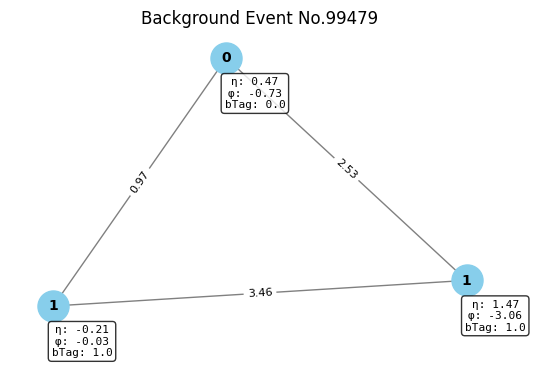

In [14]:
# from helper_function_module import visualize_graph
visualize_graph(dataset[54], save_fig = False, save_fig_path = 'eventGraph.png')

# Model Definition

In [15]:
class GCNClassifier(torch.nn.Module):
    def __init__(self, num_node_features, num_edge_features, hidden_dim, num_graph_features,*, num_hidden_graph_features=0):
        """
        GCN architecture for graph classification.

        Parameters:
        -----------
        num_node_features : int
            Number of features for each node.
        hidden_dim : int
            Dimension of the hidden layer embeddings.
        num_graph_features : int
            Number of additional graph-level features.
        """
        super(GCNClassifier, self).__init__()

        if num_hidden_graph_features != 0:
            self.classify = torch.nn.Sequential(
                torch.nn.Linear(hidden_dim + num_hidden_graph_features, 64),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(64, 1)
            )
            
            self.graph_features_nn = torch.nn.Sequential(
            torch.nn.Linear(num_graph_features, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
            torch.nn.Linear(64, num_hidden_graph_features)
            )
            
        else:
            self.classify = torch.nn.Sequential(
                torch.nn.Linear(hidden_dim + num_graph_features, 64),
                torch.nn.ReLU(),
                torch.nn.Dropout(p=0.5),
                torch.nn.Linear(64, 1)
            )

        self.lin0 = torch.nn.Linear(num_node_features, hidden_dim)
        self.edge_nn = torch.nn.Sequential(
            torch.nn.Linear(num_edge_features, 128),
             torch.nn.ReLU(),
            torch.nn.Dropout(p=0.5),
             torch.nn.Linear(128, hidden_dim * hidden_dim)
        )
        
        self.conv1 = NNConv(hidden_dim, hidden_dim, nn = self.edge_nn, aggr='max')
        self.global_mean_pool_hook = global_mean_pool
        
        

    def forward(self, data):
        """
        Forward pass of the GCN model.

        Parameters:
        -----------
        data : Data
            PyTorch Geometric Data object containing graph and its features.

        Returns:
        --------
        out : torch.Tensor
            Predicted probabilities for the graph labels.
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # GCN layers
        x = F.relu(self.lin0(x))
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        
        x = self.global_mean_pool_hook(x, data.batch)  # Shape: (batch_size, hidden_dim)

        graph_features = torch.cat([data.inv_mass_2j1p.view(-1, 1), 
                                    data.inv_mass_2j.view(-1, 1), 
                                    data.isophoton_pT.view(-1, 1)], dim=1)
        x = torch.cat([x, graph_features], dim=1)
        self.graph_embedding = x
        # Fully connected layers
        x = self.classify(x)

        return torch.sigmoid(x) 


# Trained Model Saliency Analysis

In [35]:
# Function to compute node feature saliency (gradients of output w.r.t node features)
def compute_node_feature_saliency(model, data, device):
    """Computes absolute gradients of output w.r.t. node features."""
    model.eval()
    data = data.to(device) # Ensure data is on the correct device
    # Ensure gradients are enabled ONLY for inputs we need grads for
    data.x.requires_grad_(True)
    if hasattr(data, 'edge_attr') and data.edge_attr is not None:
        data.edge_attr.requires_grad_(False) # Disable grads for edge_attr here

    try:
        output = model(data).squeeze()
        model.zero_grad() # Clear previous gradients
        # Compute gradients w.r.t. the inputs that have requires_grad=True
        output.backward()

        if data.x.grad is not None:
            feature_saliency = data.x.grad.abs().detach().cpu() # Get absolute gradients, detach, move to CPU
        else:
            print(f"Warning: Event {getattr(data,'eventno','N/A')} - No gradients computed for node features (data.x.grad is None).")
            feature_saliency = None

    except Exception as e:
        print(f"\n--- ERROR computing node feature saliency for event {getattr(data,'eventno','N/A')} ---")
        print(f"Exception: {type(e).__name__}: {e}")
        traceback.print_exc()
        feature_saliency = None
    finally:
        # Clean up requires_grad status
        data.x.requires_grad_(False)
        if hasattr(data, 'edge_attr') and data.edge_attr is not None:
            data.edge_attr.requires_grad_(False)
        # model.zero_grad() # Good practice, though done inside try

    return feature_saliency, output.detach().cpu().item() if 'output' in locals() else None

# Function to compute edge importance (gradients of output w.r.t edge attributes)
def compute_edge_attribute_importance(model, data, device):
    """Computes absolute gradients of output w.r.t. edge attributes."""
    model.eval()
    data = data.to(device)

    # Check if edge_attr exists and requires grad
    if not hasattr(data, 'edge_attr') or data.edge_attr is None or data.edge_attr.nelement() == 0:
        # print(f"Info: Event {getattr(data,'eventno','N/A')} - No edge attributes to compute importance for.")
        return None # No edge attributes

    # Ensure gradients are enabled ONLY for edge_attr
    data.edge_attr.requires_grad_(True)
    if hasattr(data, 'x') and data.x is not None:
        data.x.requires_grad_(False) # Disable grads for node features here

    edge_importance = None
    try:
        output = model(data).squeeze()
        model.zero_grad()
        # Compute gradients w.r.t. the inputs that have requires_grad=True
        output.backward()

        if data.edge_attr.grad is not None:
             # Sum absolute gradients over features (if edge_attr has multiple features)
            edge_importance = data.edge_attr.grad.abs().sum(dim=1).detach().cpu()
        else:
            print(f"Warning: Event {getattr(data,'eventno','N/A')} - No gradients computed for edge attributes (data.edge_attr.grad is None).")
            edge_importance = None

    except Exception as e:
        print(f"\n--- ERROR computing edge attribute importance for event {getattr(data,'eventno','N/A')} ---")
        print(f"Exception: {type(e).__name__}: {e}")
        traceback.print_exc()
        edge_importance = None
    finally:
        # Clean up requires_grad status
        data.edge_attr.requires_grad_(False)
        if hasattr(data, 'x') and data.x is not None:
            data.x.requires_grad_(False)
        # model.zero_grad()

    return edge_importance


def compute_average_importance(model, dataset_subset, device, node_feature_names=None):
    """
    Computes average node feature importance and edge importance over a dataset subset.

    Args:
        model: The trained PyTorch Geometric model.
        dataset_subset (list[Data]): A list of PyG Data objects to analyze.
        device: The torch device ('cuda' or 'cpu').
        node_feature_names (list[str], optional): Names of the node features for labeling.

    Returns:
        tuple: (avg_feature_importance, avg_edge_importance, feature_importance_per_node_type) or Nones
            - avg_feature_importance (Tensor | None): Avg importance per node feature across all nodes/graphs. Shape: [num_node_features]
            - avg_edge_importance (float | None): Avg edge importance across all edges/graphs.
            - feature_importance_per_node_type (dict | None): Avg feature importance split by node type (0=photon, 1=jet).
    """
    if not dataset_subset:
        print("Error: dataset_subset is empty.")
        return None, None, None

    model.to(device)
    model.eval()

    all_avg_feature_importances = []
    all_avg_edge_importances = []
    # For node type specific averages
    feature_importances_type_0 = [] # Photons
    feature_importances_type_1 = [] # Jets

    print(f"Calculating importance for {len(dataset_subset)} graphs...")
    for data in tqdm(dataset_subset, desc="Averaging Importance"):
        # --- Node Feature Importance ---
        feature_saliency, _ = compute_node_feature_saliency(model, data, device)
        if feature_saliency is not None and feature_saliency.numel() > 0:
            # Average importance per feature across nodes *in this graph*
            avg_feat_importance_graph = feature_saliency.mean(dim=0)
            all_avg_feature_importances.append(avg_feat_importance_graph)

            # Store feature importance per node type for this graph
            node_types = data.node_label.cpu() # Assuming node_type exists (0=photon, 1=jet)
            if node_types.dim() > 1:
                    node_types = node_types.squeeze() # Remove singleton dimensions
            if node_types is not None and node_types.shape[0] == feature_saliency.shape[0]:
                photon_mask = (node_types == 0)
                jet_mask = (node_types == 1)
                if photon_mask.any():
                    feature_importances_type_0.append(feature_saliency[photon_mask].mean(dim=0))
                if jet_mask.any():
                    feature_importances_type_1.append(feature_saliency[jet_mask].mean(dim=0))

        # --- Edge Attribute Importance ---
        edge_importance = compute_edge_attribute_importance(model, data, device)
        if edge_importance is not None and edge_importance.numel() > 0:
            # Average importance across all edges *in this graph*
            avg_edge_importance_graph = edge_importance.mean().item() # Get scalar value
            all_avg_edge_importances.append(avg_edge_importance_graph)

    # --- Calculate Overall Averages ---
    avg_feature_importance = None
    if all_avg_feature_importances:
        # Stack tensors and average across graphs
        avg_feature_importance = torch.stack(all_avg_feature_importances).mean(dim=0)

    avg_edge_importance = None
    if all_avg_edge_importances:
        # Average the scalar averages
        avg_edge_importance = np.mean(all_avg_edge_importances) # Use numpy for list of scalars

    # Calculate average per node type
    feature_importance_per_node_type = {}
    if feature_importances_type_0:
         feature_importance_per_node_type[0] = torch.stack(feature_importances_type_0).mean(dim=0)
    if feature_importances_type_1:
         feature_importance_per_node_type[1] = torch.stack(feature_importances_type_1).mean(dim=0)


    print("\n--- Average Importance Results ---")
    if avg_feature_importance is not None:
        print("Average Node Feature Importance (across all nodes/graphs):")
        if node_feature_names and len(node_feature_names) == len(avg_feature_importance):
            for name, val in zip(node_feature_names, avg_feature_importance):
                print(f"  {name}: {val:.5f}")
        else:
            print(f"  {avg_feature_importance.numpy()}")
    else:
        print("Average Node Feature Importance: Could not be calculated (no valid gradients?).")

    if avg_edge_importance is not None:
        print(f"\nAverage Edge Importance (across all edges/graphs): {avg_edge_importance:.5f}")
    else:
        print("Average Edge Importance: Could not be calculated (no edges or no gradients?).")

    if feature_importance_per_node_type:
         print("\nAverage Node Feature Importance by Node Type:")
         if 0 in feature_importance_per_node_type:
              print("  Type 0 (Photon):")
              vals = feature_importance_per_node_type[0]
              if node_feature_names and len(node_feature_names) == len(vals):
                  for name, val in zip(node_feature_names, vals): print(f"    {name}: {val:.5f}")
              else: print(f"    {vals.numpy()}")
         if 1 in feature_importance_per_node_type:
              print("  Type 1 (Jet):")
              vals = feature_importance_per_node_type[1]
              if node_feature_names and len(node_feature_names) == len(vals):
                  for name, val in zip(node_feature_names, vals): print(f"    {name}: {val:.5f}")
              else: print(f"    {vals.numpy()}")


    return avg_feature_importance, avg_edge_importance, feature_importance_per_node_type



def plot_average_importance(avg_feature_importance, feature_labels, avg_edge_importance, feature_importance_per_node_type=None):
    """
    Visualizes the computed average feature and edge importances.
    """
    if avg_feature_importance is None:
        print("Cannot plot average feature importance: No data provided.")
        return

    num_features = len(avg_feature_importance)
    if not feature_labels or len(feature_labels) != num_features:
        feature_labels = [f'Feature {i}' for i in range(num_features)]
        print(f"Warning: Using generic feature labels: {feature_labels}")

    fig, ax = plt.subplots(1, 1, figsize=(10, 6)) # Single plot for feature importance

    # Bar chart for average node feature importance
    feature_indices = np.arange(num_features)
    ax.bar(feature_indices, avg_feature_importance.numpy(), color='skyblue', label='Overall Avg.')
    ax.set_xticks(feature_indices)
    ax.set_xticklabels(feature_labels, rotation=45, ha='right')
    ax.set_ylabel("Average Absolute Gradient (Saliency)")
    ax.set_title("Average Node Feature Importance")
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Optionally add node type specific averages
    if feature_importance_per_node_type:
        width = 0.3 # Width for grouped bars
        if 0 in feature_importance_per_node_type: # Photons
             ax.bar(feature_indices - width/2, feature_importance_per_node_type[0].numpy(), width, color='lightcoral', label='Avg. Photon')
        if 1 in feature_importance_per_node_type: # Jets
             ax.bar(feature_indices + width/2, feature_importance_per_node_type[1].numpy(), width, color='lightgreen', label='Avg. Jet')
        ax.legend()


    # Print average edge importance separately
    if avg_edge_importance is not None:
        print(f"\nOverall Average Edge Importance: {avg_edge_importance:.5f}")
        # Add text to plot or use a separate plot if needed
        ax.text(0.95, 0.95, f'Avg. Edge Importance:\n{avg_edge_importance:.4f}',
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top', horizontalalignment='right',
                bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.5))


    plt.tight_layout()
    plt.show()

# TP, TN, FP, FN category-wise saliecy analysis functions
def classify_predictions(model, dataset, device, threshold=0.5):
    """
    Classifies predictions for a dataset into TP, TN, FP, FN categories.

    Args:
        model: The trained PyTorch Geometric model.
        dataset (list[Data] or DataLoader): The dataset to evaluate.
        device: The torch device ('cuda' or 'cpu').
        threshold (float): The probability threshold for classifying as positive (1).

    Returns:
        dict: A dictionary mapping category names ('TP', 'TN', 'FP', 'FN')
              to lists of indices corresponding to the input dataset.
    """
    model.to(device)
    model.eval()

    results = {'TP': [], 'TN': [], 'FP': [], 'FN': []}
    indices = list(range(len(dataset))) # Get original indices

    print(f"Classifying predictions for {len(dataset)} graphs...")
    with torch.no_grad():
        # Determine if dataset is a list or DataLoader
        if isinstance(dataset, torch.utils.data.DataLoader):
             print("Processing DataLoader...")
             current_index = 0
             for batch in tqdm(dataset, desc="Classifying Batches"):
                 batch = batch.to(device)
                 outputs = model(batch).squeeze() # Get model output probabilities
                 preds = (outputs >= threshold).long() # Get predicted labels (0 or 1)
                 labels = batch.y.long() # True labels

                 batch_size = labels.size(0) # Number of graphs in the batch
                 original_indices_batch = indices[current_index : current_index + batch_size]

                 for i in range(batch_size):
                     pred = preds[i].item()
                     label = labels[i].item()
                     original_idx = original_indices_batch[i] # Get original index

                     if pred == 1 and label == 1:
                         results['TP'].append(original_idx)
                     elif pred == 0 and label == 0:
                         results['TN'].append(original_idx)
                     elif pred == 1 and label == 0:
                         results['FP'].append(original_idx)
                     elif pred == 0 and label == 1:
                         results['FN'].append(original_idx)
                 current_index += batch_size

        elif isinstance(dataset, list) and all(isinstance(d, Data) for d in dataset):
             print("Processing list of Data objects...")
             for i in tqdm(indices, desc="Classifying Graphs"):
                 data = dataset[i].to(device)
                 # Handle potential batch dimension if model needs it even for single graph
                 # This depends on your model's forward implementation
                 try:
                     output = model(data).squeeze()
                 except Exception as e:
                      # May need to create a mini-batch if model expects batch dim
                      try:
                           from torch_geometric.loader import DataLoader # Local import
                           mini_loader = DataLoader([data], batch_size=1)
                           batch = next(iter(mini_loader)).to(device)
                           output = model(batch).squeeze()
                      except Exception as e2:
                           print(f"Error processing graph index {i}: {e2}")
                           continue # Skip graph if error occurs

                 pred_prob = output.item()
                 pred_label = 1 if pred_prob >= threshold else 0
                 true_label = data.y.item()

                 if pred_label == 1 and true_label == 1:
                     results['TP'].append(i)
                 elif pred_label == 0 and true_label == 0:
                     results['TN'].append(i)
                 elif pred_label == 1 and true_label == 0:
                     results['FP'].append(i)
                 elif pred_label == 0 and true_label == 1:
                     results['FN'].append(i)
        else:
            raise TypeError("Input 'dataset' must be a list of PyG Data objects or a PyG DataLoader.")


    print("\nPrediction Classification Summary:")
    for category, indices_list in results.items():
        print(f"  {category}: {len(indices_list)} samples")

    return results


def plot_category_comparison_importance(importance_results, feature_labels):
    """
    Plots grouped bar charts comparing average node feature and edge importance
    across prediction categories (TP, TN, FP, FN).

    Args:
        importance_results (dict): Dictionary mapping category names ('TP', 'TN', etc.)
                                   to tuples (avg_feature_importance, avg_edge_importance, _).
        feature_labels (list[str]): Names of the node features.
    """
    categories = ['TP', 'TN', 'FP', 'FN']
    if not feature_labels:
        print("Error: feature_labels list is required.")
        return
    num_features = len(feature_labels)

    # --- Data Preparation ---
    plot_data = {}
    category_colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, 10)) # Get some default colors
    category_color_map = {
        'TP': category_colors[0],
        'TN': category_colors[1],
        'FP': category_colors[2],
        'FN': category_colors[3]
    }

    print("\n--- Average Importance Comparison ---")
    header_feat = "|".join([f"{label:<2}" for label in feature_labels])
    print(f"{'Category':<8} | {'Avg Edge Imp':<15} | Avg Feature Imps ({header_feat})")
    print("-" * (28 + len(header_feat) ))

    for category in categories:
        avg_feat, avg_edge, _ = importance_results.get(category, (None, None, None))

        # Prepare feature importance array (ensure correct length, handle None)
        feature_vals_np = np.full(num_features, np.nan)
        valid_features = False
        if avg_feat is not None and avg_feat.numel() > 0:
            avg_feat_np = avg_feat.cpu().numpy()
            if len(avg_feat_np) == num_features:
                feature_vals_np = avg_feat_np
                valid_features = True
            else:
                print(f"Warning: Shape mismatch for '{category}' features. Expected {num_features}, got {len(avg_feat_np)}.")
                # Optionally try to pad/truncate if needed, but better to fix upstream
                # feature_vals_np[:len(avg_feat_np)] = avg_feat_np # Example: Fill what we can

        # Store edge importance (handle None)
        edge_val = avg_edge if avg_edge is not None else np.nan

        plot_data[category] = {'features': feature_vals_np, 'edge': edge_val, 'valid_features': valid_features}

        # Print summary
        edge_str = f"{edge_val:.5f}" if not np.isnan(edge_val) else "N/A"
        feat_str = ", ".join([f"{v:.5f}" if not np.isnan(v) else "N/A" for v in feature_vals_np])
        print(f"  {category:<6} | {edge_str:<15} | {feat_str}")

    # --- Plotting ---
    # Check if there's anything to plot
    if not any(d['valid_features'] for d in plot_data.values()) and all(np.isnan(d['edge']) for d in plot_data.values()):
        print("\nNo valid importance data found across all categories to plot.")
        return

    # Create figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(18, 7), gridspec_kw={'width_ratios': [3, 1]}) # Give more space to feature plot

    # == Plot 1: Node Feature Importance ==
    ax_feat = axs[0]
    x_feat = np.arange(num_features) # Label locations
    width_feat = 0.20 # Width of the bars per category
    multiplier_feat = 0
    plotted_categories_feat = []

    for category, data in plot_data.items():
        if data['valid_features']: # Only plot if feature data was valid
            offset = width_feat * multiplier_feat
            plot_vals = np.nan_to_num(data['features'], nan=0.0) # Replace NaN with 0 for plotting
            rects = ax_feat.bar(x_feat + offset, plot_vals, width_feat, label=category, color=category_color_map[category])
            multiplier_feat += 1
            plotted_categories_feat.append(category)

    if not plotted_categories_feat:
        ax_feat.text(0.5, 0.5, 'No valid feature importance data', horizontalalignment='center', verticalalignment='center', transform=ax_feat.transAxes)
    else:
        ax_feat.set_ylabel('Average Absolute Gradient (Saliency)')
        ax_feat.set_title('Average Node Feature Importance by Prediction Outcome')
        ax_feat.set_xticks(x_feat + width_feat * (len(plotted_categories_feat) - 1) / 2)
        ax_feat.set_xticklabels(feature_labels, rotation=30, ha='right')
        ax_feat.legend(loc='upper left', ncol=len(plotted_categories_feat))
        ax_feat.grid(axis='y', linestyle='--', alpha=0.7)
        ax_feat.set_ylim(bottom=0)

    # == Plot 2: Average Edge Importance ==
    ax_edge = axs[1]
    edge_categories_to_plot = [cat for cat, data in plot_data.items() if not np.isnan(data['edge'])]
    edge_values_to_plot = [data['edge'] for cat, data in plot_data.items() if not np.isnan(data['edge'])]
    edge_colors = [category_color_map[cat] for cat in edge_categories_to_plot]

    if edge_categories_to_plot:
        x_edge = np.arange(len(edge_categories_to_plot))
        ax_edge.bar(x_edge, edge_values_to_plot, color=edge_colors, width=0.6)
        ax_edge.set_ylabel('Average Absolute Gradient (Saliency)')
        ax_edge.set_title('Average Edge Importance')
        ax_edge.set_xticks(x_edge)
        ax_edge.set_xticklabels(edge_categories_to_plot)
        ax_edge.grid(axis='y', linestyle='--', alpha=0.7)
        ax_edge.set_ylim(bottom=0)
    else:
        ax_edge.text(0.5, 0.5, 'No valid edge importance data', horizontalalignment='center', verticalalignment='center', transform=ax_edge.transAxes)
        ax_edge.set_title('Average Edge Importance')


    fig.suptitle("GNN Feature & Edge Importance by Prediction Outcome", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()




Calculating importance for 50 graphs...


Averaging Importance: 100%|██████████| 50/50 [00:00<00:00, 272.21it/s]


--- Average Importance Results ---
Average Node Feature Importance (across all nodes/graphs):
  Eta: 0.09401
  Phi: 0.08086
  b_tag: 0.14708

Average Edge Importance (across all edges/graphs): 0.10981

Average Node Feature Importance by Node Type:
  Type 0 (Photon):
    Eta: 0.09217
    Phi: 0.10428
    b_tag: 0.14352
  Type 1 (Jet):
    Eta: 0.09493
    Phi: 0.06915
    b_tag: 0.14886



Overall Average Edge Importance: 0.10981


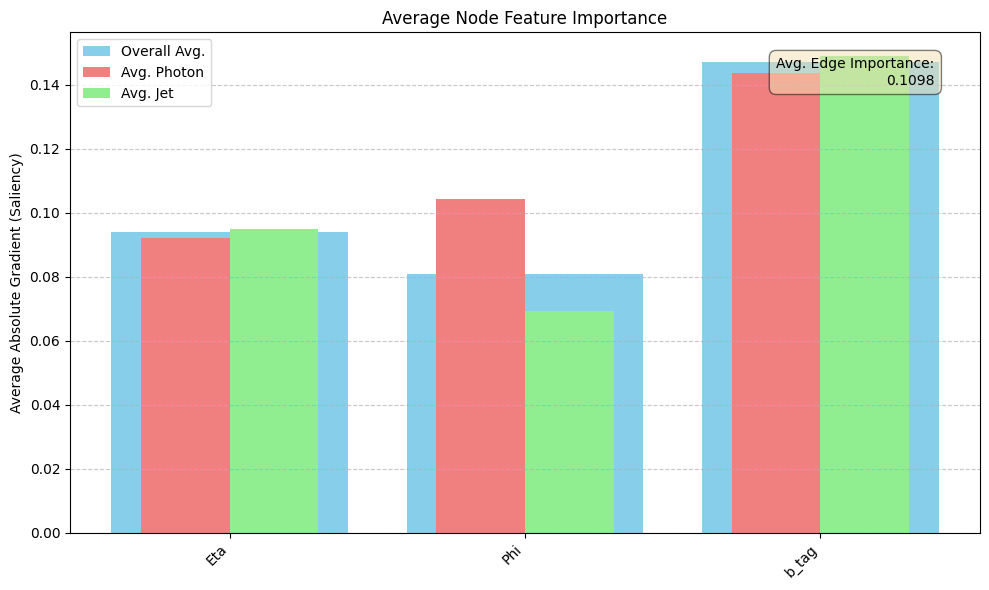

Classifying predictions for 5760 graphs...
Processing list of Data objects...


Classifying Graphs: 100%|██████████| 5760/5760 [00:04<00:00, 1356.64it/s]



Prediction Classification Summary:
  TP: 1537 samples
  TN: 3683 samples
  FP: 140 samples
  FN: 400 samples

--- Computing Importance for TP (1537 samples) ---
Calculating importance for 1537 graphs...


Averaging Importance: 100%|██████████| 1537/1537 [00:07<00:00, 218.90it/s]



--- Average Importance Results ---
Average Node Feature Importance (across all nodes/graphs):
  Eta: 0.04482
  Phi: 0.03655
  b_tag: 0.08911

Average Edge Importance (across all edges/graphs): 0.05388

Average Node Feature Importance by Node Type:
  Type 0 (Photon):
    Eta: 0.04519
    Phi: 0.04124
    b_tag: 0.08092
  Type 1 (Jet):
    Eta: 0.04464
    Phi: 0.03420
    b_tag: 0.09321

--- Computing Importance for TN (3683 samples) ---
Calculating importance for 3683 graphs...


Averaging Importance: 100%|██████████| 3683/3683 [00:15<00:00, 230.76it/s]



--- Average Importance Results ---
Average Node Feature Importance (across all nodes/graphs):
  Eta: 0.02077
  Phi: 0.02350
  b_tag: 0.04215

Average Edge Importance (across all edges/graphs): 0.02290

Average Node Feature Importance by Node Type:
  Type 0 (Photon):
    Eta: 0.01530
    Phi: 0.02397
    b_tag: 0.03526
  Type 1 (Jet):
    Eta: 0.02351
    Phi: 0.02327
    b_tag: 0.04560

--- Computing Importance for FP (140 samples) ---
Calculating importance for 140 graphs...


Averaging Importance: 100%|██████████| 140/140 [00:00<00:00, 232.89it/s]



--- Average Importance Results ---
Average Node Feature Importance (across all nodes/graphs):
  Eta: 0.13594
  Phi: 0.11260
  b_tag: 0.27807

Average Edge Importance (across all edges/graphs): 0.15375

Average Node Feature Importance by Node Type:
  Type 0 (Photon):
    Eta: 0.14107
    Phi: 0.12882
    b_tag: 0.24820
  Type 1 (Jet):
    Eta: 0.13337
    Phi: 0.10449
    b_tag: 0.29300

--- Computing Importance for FN (400 samples) ---
Calculating importance for 400 graphs...


Averaging Importance: 100%|██████████| 400/400 [00:01<00:00, 231.07it/s]
/tmp/ipykernel_24054/3679492978.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  category_colors = plt.cm.get_cmap('tab10')(np.linspace(0, 1, 10)) # Get some default colors



--- Average Importance Results ---
Average Node Feature Importance (across all nodes/graphs):
  Eta: 0.05661
  Phi: 0.07018
  b_tag: 0.11953

Average Edge Importance (across all edges/graphs): 0.06566

Average Node Feature Importance by Node Type:
  Type 0 (Photon):
    Eta: 0.04274
    Phi: 0.06599
    b_tag: 0.09913
  Type 1 (Jet):
    Eta: 0.06355
    Phi: 0.07228
    b_tag: 0.12974

--- Importance Calculation Complete for All Categories ---

--- Average Importance Comparison ---
Category | Avg Edge Imp    | Avg Feature Imps (Eta       |Phi       |b_tag     )
------------------------------------------------------------
  TP     | 0.05388         | 0.04482, 0.03655, 0.08911
  TN     | 0.02290         | 0.02077, 0.02350, 0.04215
  FP     | 0.15375         | 0.13594, 0.11260, 0.27807
  FN     | 0.06566         | 0.05661, 0.07018, 0.11953


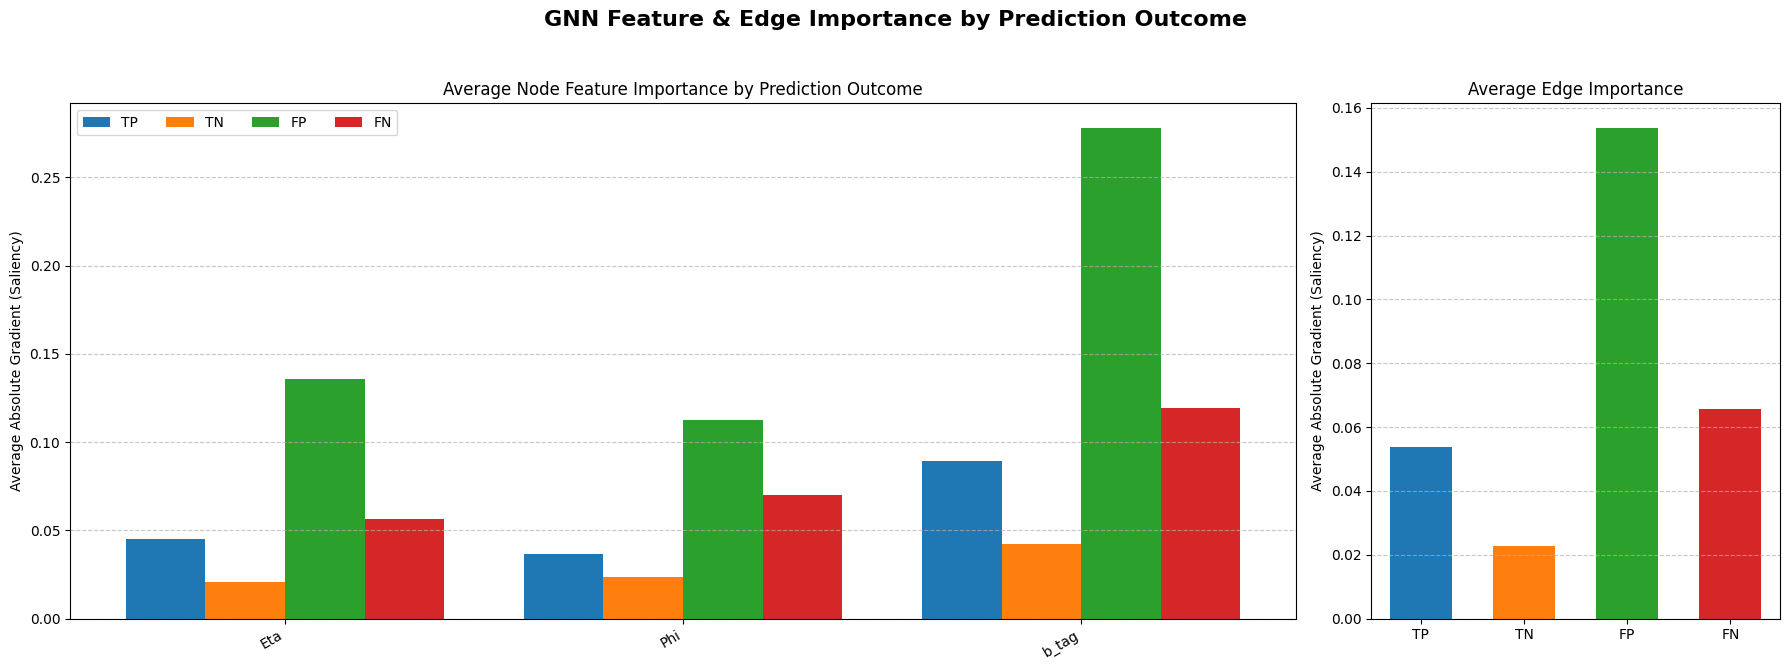

In [31]:
if __name__ == '__main__':
    # Trained Model Loading
    model = GCNClassifier(num_node_features=3,
                          num_edge_features = 1,
                          hidden_dim=10,
                          num_graph_features=3,
                          num_hidden_graph_features = 0).to(device)
    
    filepath = "./minpt10/saved_models/bestModel_1_ax15minpt10_NNConv_onlyFirst2bj_onlyFirst1p.pt"
    try:
        checkpoint = torch.load(filepath, map_location=device)
        print("--- Model Checkpoint Loaded Successfully :)")
    except Exception as e:
        print(f"*** Model Checkpoint Loading Failed: {e}")
        traceback.print_exc()
    
    try:
        model.load_state_dict(checkpoint['model_state_dict'])
        print("--- Trained Model Weights Loaded Successfully :)")
    except Exception as e:
        print(f"*** Trained Weights can't be Loaded: {e}")
        traceback.print_exc()

    
    num_of_samples = 50
    if 'dataset' in locals() and dataset:
        dataset_subset = dataset[:num_of_samples] # Use a small subset for quick testing
        node_feature_names = ['Eta', 'Phi', 'b_tag'] # Define based on your data.x

        if dataset_subset:
            # Compute average importances
            avg_feat_importance, avg_edge_importance, feat_importance_by_type = compute_average_importance(
                    model,
                    dataset_subset,
                    device,
                    node_feature_names=node_feature_names
                )
    
            # Plot the averages
            if avg_feat_importance is not None:
                plot_average_importance(
                        avg_feat_importance,
                        node_feature_names,
                        avg_edge_importance,
                        feature_importance_per_node_type=feat_importance_by_type
                        )
            else:
                print("Could not compute average importances to plot.")
        else:
            print("Dataset subset is empty. Cannot compute averages.")
    
        # Classify predictions
        prediction_categories = classify_predictions(model, dataset, device) # Use the full dataset or test set
    
        # Compute average importance for each category
        average_importances_by_category = {}
    
        for category, indices in prediction_categories.items():
            print(f"\n--- Computing Importance for {category} ({len(indices)} samples) ---")
            if not indices:
                print(f"Skipping {category} as there are no samples.")
                average_importances_by_category[category] = (None, None, None) # Store None tuple
                continue
    
            # Create the subset of data for this category
            subset_data = [dataset[i] for i in indices]
    
            # Compute averages for this subset
            avg_feat, avg_edge, feat_by_type = compute_average_importance(
                model,
                subset_data,
                device,
                node_feature_names=node_feature_names
            )
            average_importances_by_category[category] = (avg_feat, avg_edge, feat_by_type)
    
        print("\n--- Importance Calculation Complete for All Categories ---")
        # Now `average_importances_by_category` holds the results, e.g.:
        # average_importances_by_category['TP'] = (tensor_feat, scalar_edge, dict_feat_by_type)
        # average_importances_by_category['FP'] = (tensor_feat, scalar_edge, dict_feat_by_type)
        # ... etc.
        if 'average_importances_by_category' in locals():
            # 5. Plot the comparison
            plot_category_comparison_importance(
                average_importances_by_category,
                node_feature_names # Use the same feature names
            )
        else:
             print("\nCould not compute or find importance results for plotting.")
    else:
        print("Please load your 'dataset' (list of PyG Data objects) and 'model' first.")